# Determine expression relationships between constructs
Correlations between aggregate groups are compared

## Imports

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Find the root of the git repo on the host system

In [2]:
# Get the current working directory
cwd = Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Import helper correlation class

In [3]:
sys.path.append(
    f"{root_dir}/0.data_analysis/construct_phenotypic_expression_plate_4_fs_data/utils"
)
import create_correlations as cc

## Define Paths

In [4]:
# Change this filename when plate 4 is available
filename = "Plate_4_sc_norm_fs.parquet"

# Path to the plate data
path = Path(
    f"{root_dir}/nf1_painting_repo/3.processing_features/data/feature_selected_data/{filename}"
)

# Add the output path here:
output_path_figures = Path("figures")

output_path_data = Path("data")

# Create the directories if they don't exist
output_path_figures.mkdir(parents=True, exist_ok=True)
output_path_data.mkdir(parents=True, exist_ok=True)

## Load the data

In [5]:
platedf = pd.read_parquet(path)

# Aggregating

In [6]:
meta_prefix = "Metadata"

# Columns that do not contain Metadata
not_meta_cols = [col for col in platedf.columns if meta_prefix not in col]

In [7]:
median_cols = {col_name: "median" for col_name in not_meta_cols}

# Set metadata columns to lambda functions set to the first row
meta_cols = {
    col_name: lambda x: x.iloc[0]
    for col_name in platedf.columns
    if meta_prefix in col_name
}

# Combine the dictionaries
median_cols.update(meta_cols)

# Aggregate the plate data
platedf = platedf.groupby("Metadata_Well").agg(median_cols)

## Create correlations object

In [8]:
corr_obj = cc.CreateCorrelations(platedf=platedf, aggregated=True)

## Save the correlation data

In [9]:
final_construct = corr_obj.final_construct
final_construct.to_csv(output_path_data / "correlation_data.tsv", sep="\t", index=False)

## Create x labels for constructs

In [10]:
name_map = {"NF1 Target 1": "(Construct 1)", "NF1 Target 2": "(Construct 2)", "Scramble": "(Scramble)", "no_treatment": "(No Treatment)"}
final_construct["construct_groups"] =  final_construct['first_construct'].map(name_map) + " and " + final_construct['second_construct'].map(name_map)

In [11]:
final_construct["second_construct"].unique()

array(['Scramble', 'no_treatment', 'NF1 Target 2', 'NF1 Target 1'],
      dtype=object)

## Create boxplots for each concentration

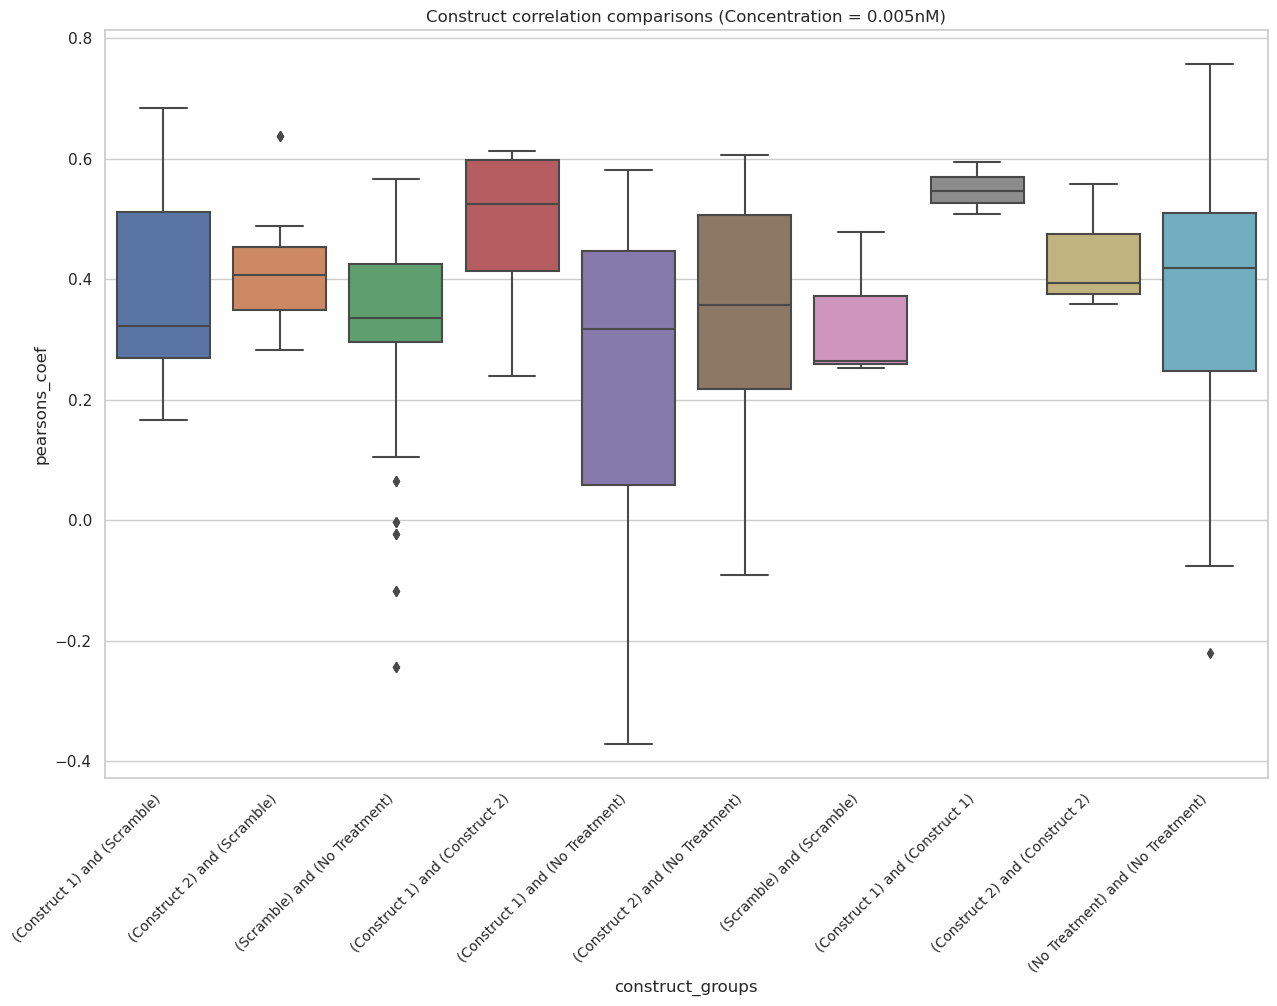

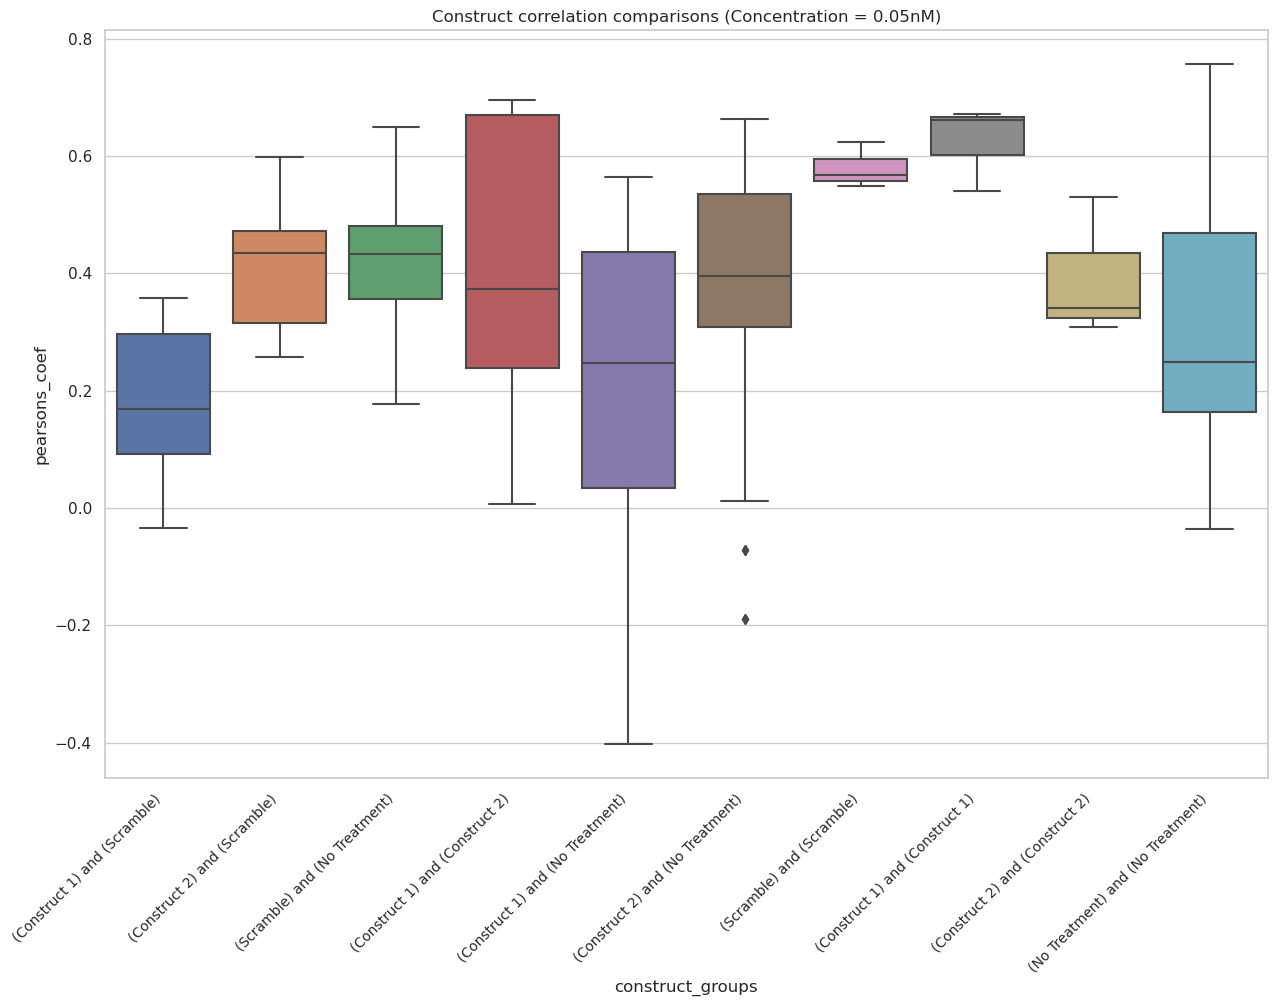

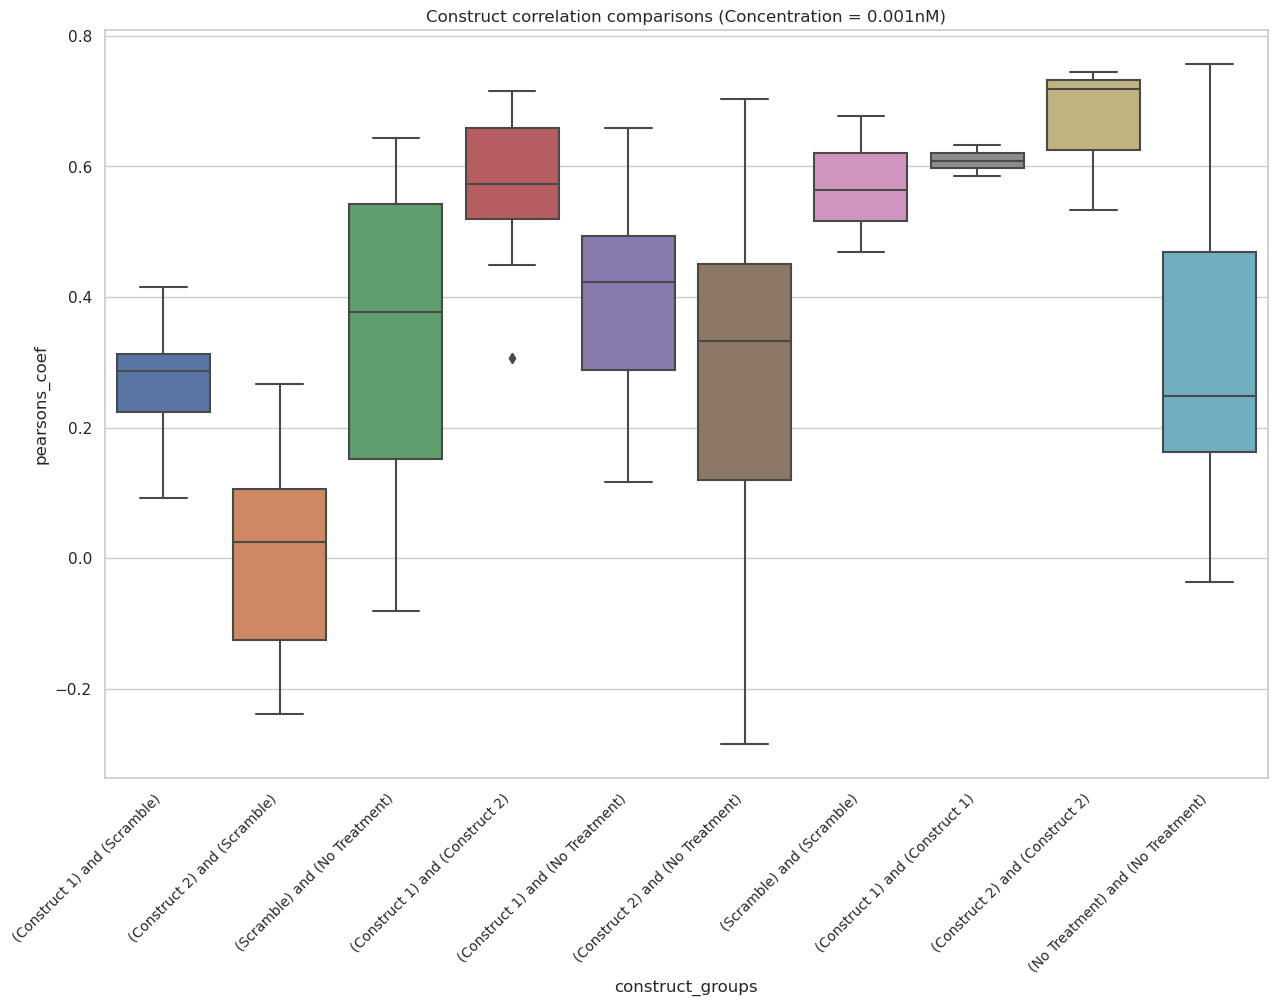

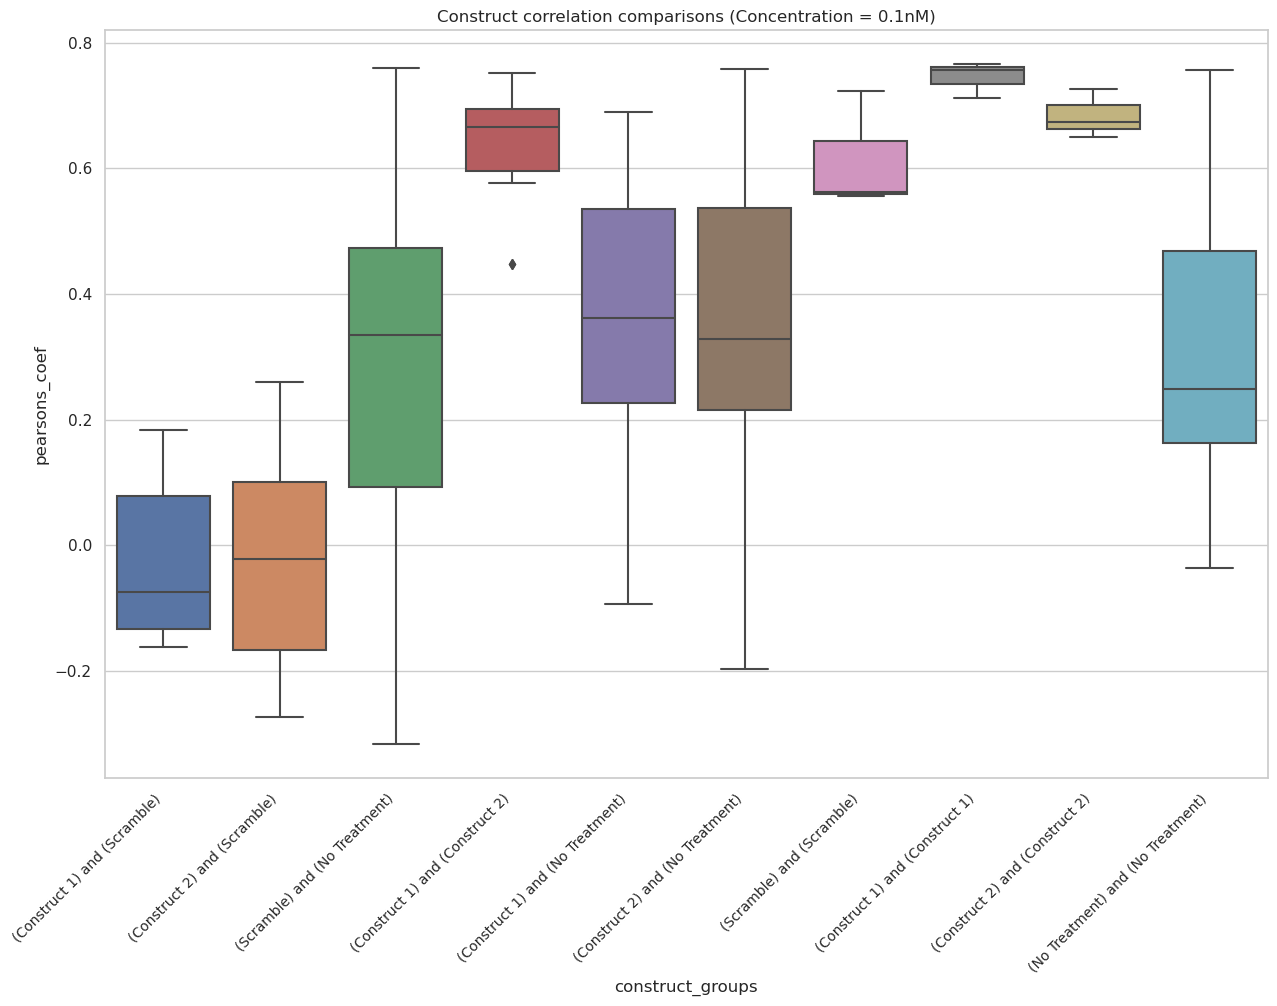

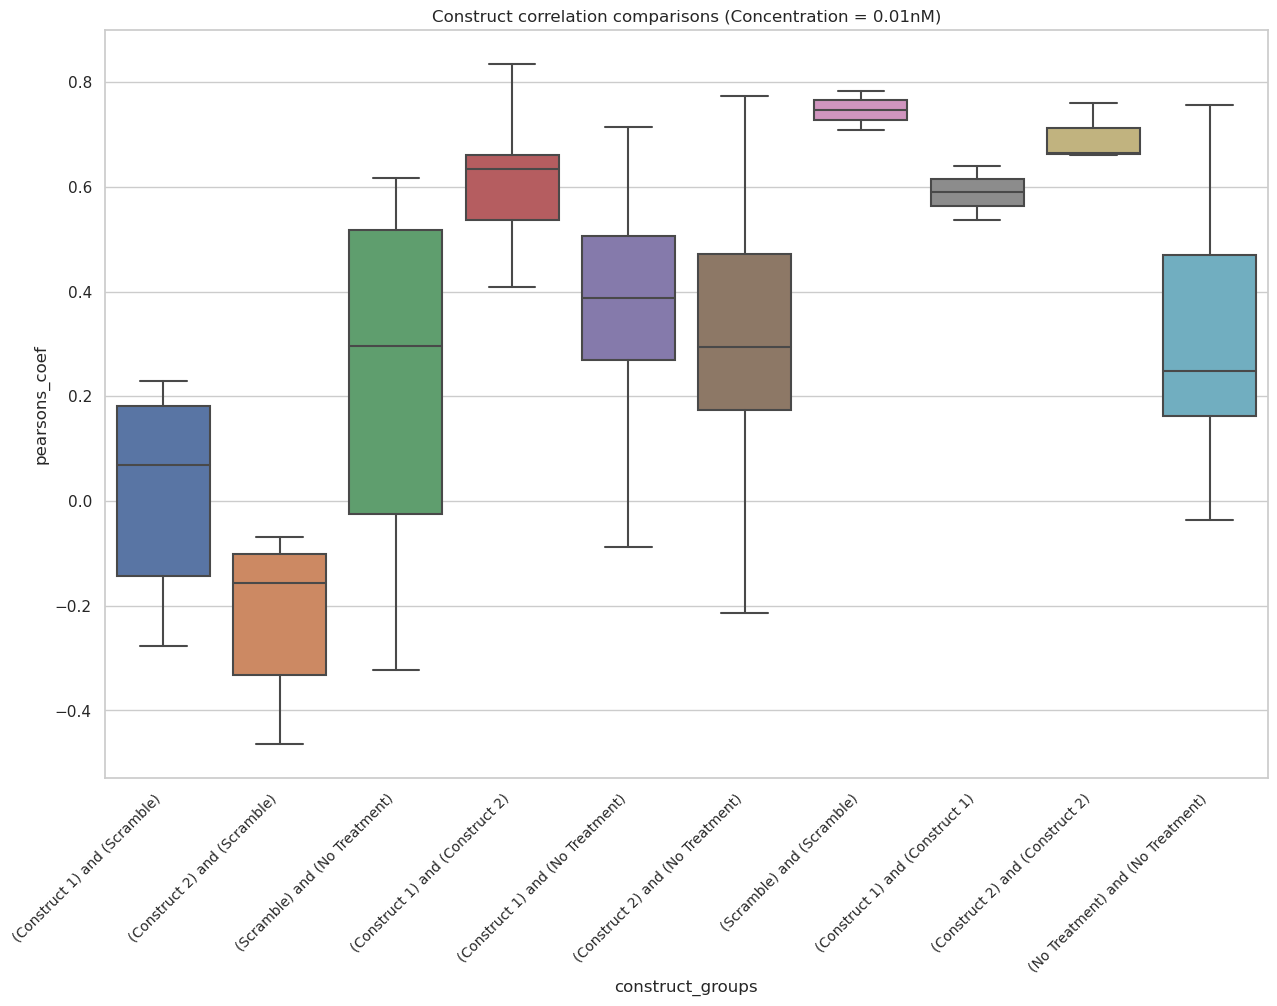

In [12]:
sns.set(style="whitegrid")

for conc in final_construct["concentration"].unique():
    fig, ax = plt.subplots(figsize=(15, 11))

    # Create a boxplot for each concentration
    conc_filt = (final_construct["concentration"] == conc)
    df = final_construct.loc[conc_filt]

    ax = sns.boxplot(x="construct_groups", y="pearsons_coef", data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.subplots_adjust(bottom=0.2)
    plt.title(f"Construct correlation comparisons (Concentration = {conc}nM)")

    plt.savefig(f"figures/construct_correlation_comparisons_{conc}nM.png")
    plt.show()